In [23]:
import jax.numpy as np
import jax.nn as nn
import numpy as onp
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
#from jax.experimental import optimizers
import jax.example_libraries.optimizers as optimizers
#from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
import pandas as pd
config.update("jax_enable_x64", True)
plt.rcParams.update({'font.size': 12})

import pandas as pd
from sklearn.metrics import r2_score

In [24]:
## Read in the RVE 

## all the connectivity of the RVE and nodes in the boundary 
cell_connectivity = # array with nodes that make up a cell 

## the vertex coordinates 
node_X # vector of n_vert by 3 



In [ ]:
# initial guess for deformed RVE is just the original RVE 
node_x = np.copy.deep_copy((node_X))

In [ ]:
## Functions to calculate initial volumes, areas, lengths 
cell0_volume_array = [] # store initial volumes later, n_cells by 1 
face0_area_array = [] #store initial areas for later, 2*n_faces by 1
egde0_length_array = [] # store initial lengths for later, we might get number of E, then we can see how many times we over-count

In [ ]:
## Functions to calculate the energy
def evalPsi(RVE__topology_info,node_X,node_x):
    # compute the deformed volumes, areas and lengths 
    cell_volume_array = calc_volume_per_cell(node_x,RVE__topology_info)
    face_area_array = calc_area_per_face(node_x,RVE__topology_info)
    edge_length_array = calc_length_per_edge(node_x,RVE__topology_info)
    # energy is going to be three components 
    Psi_vol = kvol*np.sum (( cell_volume_array - cell0_volume_array)**2)
    #J = cell_volume_array/cell0_volume_array
    #Psi_vol = neoHookean_vol_part(J)
    Psi_area = karea*np.sum (( face_area_array - face0_area_array)**2)/2
    Psi_length = klength*np.sum (( edge_length_array - edge0_length_array)**2)/edge_overcount 
    return Psi_vol+Psi_area+Psi_length

In [ ]:
## 'loss'
@jit
def loss_RVE(node_x, loss_args):
    node_X = loss_args[0]
    RVE_topology = loss_args[1]
    
    # call the energy 
    Psi_tot = evalPsi(RVE__topology_info,node_X,node_x)
    
    # over-write the position of the nodes that we can apply BC to 
    PBC_penalty = 0
    beta = 10 # penalty to try to enforce the constraint 
    dPBC = [1,0,-1] # the displacements we want to apply 
    for i in range(BC_pairs):
        n1 = BC_pair[i,0]
        n2 = BC_pair[i,1]
        for j in range(3):
            # apply 
            PBC_penalty += beta*((node_x[n1,j]-node_x[n2,j])-dPBC[j]*BC_pair[i,j+2])**2
            
    # prevent rigid body motions 
    # overwrite completely at least one node for preventing rigid body translation
    node_x[rbt_node] = node_X[rbt_node]
    node_x[rbrotx_node,0] = node_X[rbrotx_node,0]
    node_x[rbroty_node,1] = node_X[rbroty_node,1]
    node_x[rbrotz_node,2] = node_X[rbrotz_node,2]
    
    return Psi_tot + PBC_penalty
    



In [ ]:
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(node_x)
node_x_it1, train_loss, val_loss = train_jp(loss_RVE, loss_args, opt_state, key, nIter = 10000) #Original 100000



In [3]:
## layers for AE for single chart
layers_E = [3, 5, 5, 2]
layers_D = [2, 5, 5, 3]
params_E = init_params_b(layers_E, key)
params_D = init_params_b(layers_D, key)
params_AE_F = [params_E,params_D]
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(params_AE_F)
#params_AE_F1, train_loss, val_loss = train_jp(loss_AE, X_full, opt_state, key, nIter = 10000) #Original 100000

In [4]:
## multi chart
## test building extra data with labels t=0,1 for two charts
Xt0 = onp.hstack([X_full,onp.zeros((len(X_full),1))])
Xt1 = onp.hstack([X_full,onp.ones((len(X_full),1))])
#Xt = onp.vstack([Xt0,Xt1])
#Xt.shape
layers_Et = [4, 10, 10, 2]
params_Et = init_params_b(layers_Et, key)
#Z = forward_pass_b(Xt, params_Et)
Zt0 = forward_pass_b(Xt0, params_Et)
Zt1 = forward_pass_b(Xt1, params_Et)
Zt0t0 = np.hstack([Zt0,np.zeros((len(Zt0),1))])
Zt1t1 = np.hstack([Zt1,np.ones((len(Zt1),1))])
#Zt = np.vstack([Zt0,Zt1])
layers_Dt = [3, 10, 10, 3]
params_Dt = init_params_b(layers_Dt, key)
X_rt0 = forward_pass_b(Zt0t0, params_Dt)
X_rt1 = forward_pass_b(Zt1t1, params_Dt)

In [25]:
## loss for the multi-chart parameterization 
@jit
def loss_AEMC(params, X):
    # for the encoder take in a label t either 0 or 1 
    Xt0 = np.hstack([X,np.zeros((len(X),1))])
    Xt1 = np.hstack([X,np.ones((len(X),1))])
    #Xt = onp.vstack([Xt0,Xt1])
    Zt0 = forward_pass_b(Xt0, params[0])
    Zt1 = forward_pass_b(Xt1, params[0])
    # for the decoder stack Z with the label 
    Zt0t0 = np.hstack([Zt0,np.zeros((len(Zt0),1))])
    Zt1t1 = np.hstack([Zt1,np.ones((len(Zt1),1))])
    #Zt = np.vstack([Zt0,Zt1])
    X_rt0 = forward_pass_b(Zt0t0, params[1])
    X_rt1 = forward_pass_b(Zt1t1, params[1])
    #
    # combine into the loss that tries to choose between the two parameterizations
    alpha = jax.nn.sigmoid(100*forward_pass_b(X_full, params_tw))
    Lvec = alpha*(X_full - X_rt0)**2 + (1-alpha)*(X_full - X_rt1)**2    
    return np.mean((Lvec[:,0])+(Lvec[:,1])+(Lvec[:,2]))

@partial(jit, static_argnums=(0,))
def step_jp(loss, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch)
    return opt_update(i, g, opt_state)

def train_jp(loss, X, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, it, opt_state, X)         
        if (it+1)% 1000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

In [6]:
layers_E = [4, 10, 10, 2]
layers_D = [3, 10, 10, 3]
layers_a = [3, 10, 10, 1]
params_E = init_params_b(layers_E, key)
params_D = init_params_b(layers_D, key)
params_a = init_params_b(layers_a, key)

params_AEMC = [params_E,params_D,params_a]
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(params_AEMC)
#params_AEMC1, train_loss, val_loss = train_jp(loss_AEMC, X_full, opt_state, key, nIter = 10000) #Original 100000

## Shell analysis as hyperelastic energy minimization

* The initial decoder is fixed and defines the metric nad curvature tensors from initial shell geometry $X=[X,Y,Z]$
* Use a decoder from $u,v,t$ (where to is just the chart choice) to $x=[x,,y,z]$ where $x,y,z$ are the deformed coordinates 
* Derivatives of this map define the metric and the curvature of the deformed surface. Energy is simply change in metric and curvature 
* There are general two choices for the Dirichlet boundary conditions, either exactly enforced, or penalty enforced. From experience with Amir, let's do exactly enforced and only try the penalty afterwards. 
* Minimization of the strain energy minus work done by external forces, i.e. natural boundary conditions after

The first example to try is to do a sphere with a pinch at top and bottom.  



In [26]:
## Assuming the multichart decoder has been run, let's just read the parameters 
with open('full_param_t', 'rb') as f:
    params = onp.load(f,allow_pickle=True)

In [27]:
import matplotlib.colors as mcolors
colors = [(1.,0.,0.,c) for c in onp.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmapR', colors, N=5)
colors = [(0.,0.,1.,c) for c in onp.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmapB', colors, N=5)

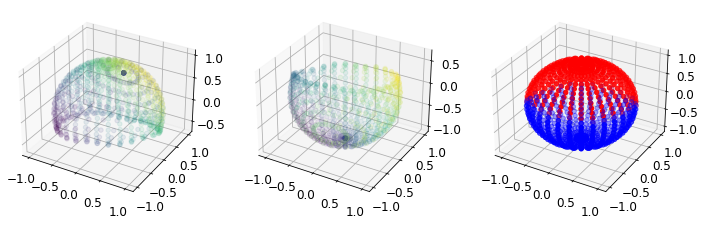

In [64]:
# test quickly 
# params_E = params[0]
# params_D = params[1]
# params_a = params[2]
X_full = genUSphPtsF(30)
# check the parameterization of each chart separately 
Xdense_t0 = np.hstack([X_full,np.zeros((len(X_full),1))])
Z_t0 = forward_pass_b(Xdense_t0, params[0])
Z_t0t0 = np.hstack([Z_t0,np.zeros((len(Z_t0),1))])
X_rt0 = forward_pass_b(Z_t0t0, params[1])
label_full_d = X_full[:,0]+X_full[:,1]+X_full[:,2]
# check the parameterization of each chart separately 
Xdense_t1 = np.hstack([X_full,np.ones((len(X_full),1))])
Z_t1 = forward_pass_b(Xdense_t1, params[0])
Z_t1t1 = np.hstack([Z_t1,np.ones((len(Z_t1),1))])
X_rt1 = forward_pass_b(Z_t1t1, params[1])
# for last plot get the total parameterization using the classifier
tlabel = jax.nn.sigmoid(100*forward_pass_b(X_full, params[2]))
Xr = tlabel*X_rt0 + (1-tlabel)*X_rt1
# PLOT
fig,axs = plt.subplots(1,3,figsize=(12,4),subplot_kw={'projection': '3d'})
axs[0].scatter(X_rt0[:,0],X_rt0[:,1],X_rt0[:,2],c=label_full_d,alpha=0.1)
axs[1].scatter(X_rt1[:,0],X_rt1[:,1],X_rt1[:,2],c=label_full_d,alpha=0.1)
axs[2].scatter(X_rt1[:,0],X_rt1[:,1],X_rt1[:,2],c=1-tlabel, cmap = cmapblue)
axs[2].scatter(X_rt0[:,0],X_rt0[:,1],X_rt0[:,2],c=tlabel, cmap = cmapred)

In [36]:
## some checks for the calculation of the metric before we try to add it to the loss 
# derivatives with respect to middle layer 
eval_dX1rdUVt = grad(lambda z: forward_pass_b(z, params[1])[0])
eval_dX2rdUVt = grad(lambda z: forward_pass_b(z, params[1])[1])
eval_dX3rdUVt = grad(lambda z: forward_pass_b(z, params[1])[2])
eval_dX1rdUVt_vmap = vmap(eval_dX1rdUVt)
eval_dX2rdUVt_vmap = vmap(eval_dX2rdUVt)
eval_dX3rdUVt_vmap = vmap(eval_dX3rdUVt)

In [37]:
# evaluate to try to get the metric 
# metric for one chart 
dX1rdUVT_t0 = eval_dX1rdUVt_vmap(Z_t0t0)
dX2rdUVT_t0 = eval_dX2rdUVt_vmap(Z_t0t0)
dX3rdUVT_t0 = eval_dX3rdUVt_vmap(Z_t0t0)
# metric for the other chart 
dX1rdUVT_t1 = eval_dX1rdUVt_vmap(Z_t1t1)
dX2rdUVT_t1 = eval_dX2rdUVt_vmap(Z_t1t1)
dX3rdUVT_t1 = eval_dX3rdUVt_vmap(Z_t1t1)

## 
# G1 = dX/dU #3x1 vector of derivative of X vector wrt U coord
# G2 = dX/dV #3x1 vector of derivative of X vector wrt V coord
# N = G1xG2/||G1xG2||
# this 3D tensor is a metric 
# G3D = [ G1 G2 N ] # columns are the tangent vectors and normal 
# G3Dinv = [ G^1, G^2, N] # the rows of G3d inv are the contravariant vectors 
# first fundamental form of the surface (Related to the metric)
# G2D = [[G1 dot G1, G1 dot G2],[G2 dot G1, G2 dot G2]
# G2Dinv 
# G^1 = G2Dinv_{alpha beta} * G_beta = G2dinv_11 * G1 + G2dinv_12 * G2
# G^2 = G2Dinv_{alpha beta} * G_beta = G2dinv_21 * G1 + G2dinv_22 * G2 
# to check, G^1 dot G1 = 1, G^1 dot G2 = 0, G^2 dot G1 = 0, G^2 dot G2 = 1
# that's the definition of contravariant vectors 

# deformation gradient in 3D 
# Fs = g1 dyadic G^1 + g2 dyadic G^2 # 3x3 but singular, but looks like full matrix 
# deformation gradient associated to membrane strain from reference surface X to deformed surface x 
# if you want to see the zero in the last column and last row, you can rotate to a coordinate system aligned with
# normal 
# There must be a way of directly getting this in the 2x2 form, but be careful because G1, G2 are not orthonormal 
# BASIS = G1 dyadic G^1 + G1 dyadic G^2 + G2 dyadic G^1 + G2 dyadic G^2 
# A =  A11* G1 dyadic G^1 + A12* G1 dyadic G^2 + A21* G2 dyadic G^1 + A22* G2 dyadic G^2 
# above the full representatin of tensor A with the explicit tensor basis, which again, is NOT orthonormal 
# A = [[A11, A12],[A21, A22]] the 2D representation of tensor A 
# unilile e1 = [1,0,0], e2 = [ 0,1,0], e3 = [0,0,1]

# E = 0.5*( F^T F - I )
# E = 0.5*(g_{alpha beta} - G_{alpha beta})*G^alpha dyadic G^beta
# traceE = not just sum of diagonal component but the basis also contributes to the trace 
# E:E 

In [38]:
# construct the metric components 
# one chart
Guu_t0 = dX1rdUVT_t0[:,0]**2 + dX2rdUVT_t0[:,0]**2 + dX1rdUVT_t0[:,0]**2
Gvv_t0 = dX1rdUVT_t0[:,1]**2 + dX2rdUVT_t0[:,1]**2 + dX1rdUVT_t0[:,1]**2
Guv_t0 = dX1rdUVT_t0[:,0]*dX1rdUVT_t0[:,1] + dX2rdUVT_t0[:,0]*dX2rdUVT_t0[:,1] + dX1rdUVT_t0[:,0]*dX1rdUVT_t0[:,1]
# the other chart
Guu_t1 = dX1rdUVT_t1[:,0]**2 + dX2rdUVT_t1[:,0]**2 + dX1rdUVT_t1[:,0]**2
Gvv_t1 = dX1rdUVT_t1[:,1]**2 + dX2rdUVT_t1[:,1]**2 + dX1rdUVT_t1[:,1]**2
Guv_t1 = dX1rdUVT_t1[:,0]*dX1rdUVT_t1[:,1] + dX2rdUVT_t1[:,0]*dX2rdUVT_t1[:,1] + dX1rdUVT_t1[:,0]*dX1rdUVT_t1[:,1]

# invariants might be nicer to plot
traceG_t0 = Guu_t0 + Gvv_t0
detG_t0 = Guu_t0*Gvv_t0 - Guv_t0**2
traceG_t1 = Guu_t1 + Gvv_t1
detG_t1 = Guu_t1*Gvv_t1 - Guv_t1**2

In [39]:
# maybe I want to only plot the points in UV space that matter and collapse all other points
U_t0_a = Z_t0[:,0]*tlabel[:,0]
V_t0_a = Z_t0[:,1]*tlabel[:,0]
U_t1_a = Z_t1[:,0]*(1-tlabel[:,0])
V_t1_a = Z_t1[:,1]*(1-tlabel[:,0])

In [40]:
## trying to add a colormap with transparency
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

<ipython-input-40-dfb28bd65a39>:15: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)


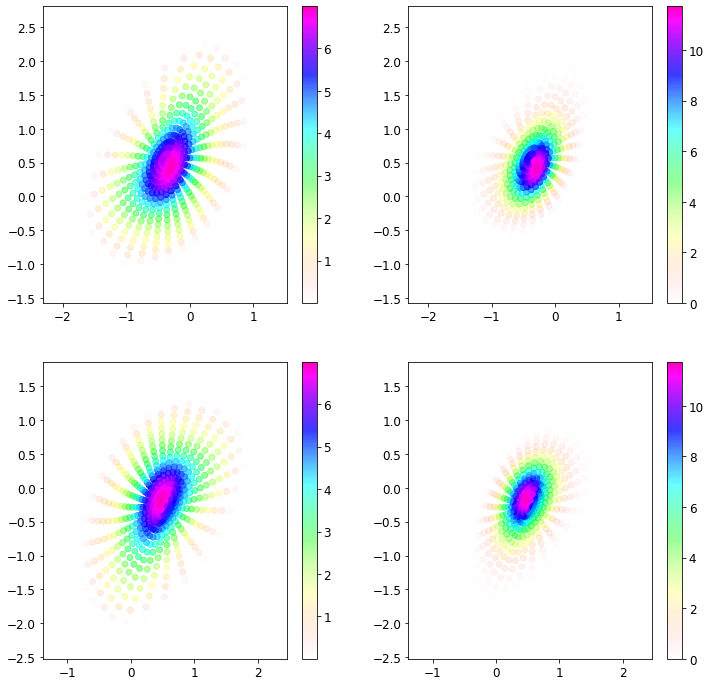

In [41]:
# plot the metric, which is inherently an intrinsic geometry measure 
# in other words it only depends on the parameterization and not the ambient space 
fig,axs = plt.subplots(2,2,figsize=(12,12))
sc1 = axs[0,0].scatter(Z_t0[:,0],Z_t0[:,1],c=traceG_t0*tlabel[:,0], cmap='rainbow_alpha')
sc2 = axs[0,1].scatter(Z_t0[:,0],Z_t0[:,1],c=detG_t0*tlabel[:,0], cmap='rainbow_alpha')
sc3 = axs[1,0].scatter(Z_t1[:,0],Z_t1[:,1],c=traceG_t1*(1-tlabel[:,0]), cmap='rainbow_alpha')
sc4 = axs[1,1].scatter(Z_t1[:,0],Z_t1[:,1],c=detG_t1*(1-tlabel[:,0]), cmap='rainbow_alpha')
# sc1 = axs[0,0].scatter(U_t0_a,V_t0_a,c=traceG_t0)
# sc2 = axs[0,1].scatter(U_t0_a,V_t0_a,c=detG_t0)
# sc3 = axs[1,0].scatter(U_t1_a,V_t1_a,c=traceG_t1)
# sc4 = axs[1,1].scatter(U_t1_a,V_t1_a,c=detG_t1)
plt.colorbar(sc1,ax=axs[0,0])
plt.colorbar(sc2,ax=axs[0,1])
plt.colorbar(sc3,ax=axs[1,0])
plt.colorbar(sc4,ax=axs[1,1])

In [42]:
def writeVTK(X,vector,filename):
    myfile = open(filename,'w')
    myfile.write("# vtk DataFile Version 2.0\nSurface\nASCII\nDATASET POLYDATA\nPOINTS %i float\n"%len(X))
    for i in range(len(X)):
        myfile.write('%f %f %f\n'%(X[i,0],X[i,1],X[i,2]))
    myfile.write("VERTICES %i %i\n"%(len(X),2*len(X)))
    for i in range(len(X)):
        myfile.write('1 %i\n'%i)
    myfile.write('POINT_DATA %i\nVECTORS vectors float\n'%len(vector))
    for i in range(len(vector)):
        myfile.write('%f %f %f\n'%(vector[i,0],vector[i,1],vector[i,2]))
    myfile.close()
    return 0

In [67]:
# calculate normals for reference geometry 

nx_t0 = dX2rdUVT_t0[:,0]*dX3rdUVT_t0[:,1] - dX3rdUVT_t0[:,0]*dX2rdUVT_t0[:,1]
ny_t0 = dX3rdUVT_t0[:,0]*dX1rdUVT_t0[:,1] - dX1rdUVT_t0[:,0]*dX3rdUVT_t0[:,1]
nz_t0 = dX1rdUVT_t0[:,0]*dX2rdUVT_t0[:,1] - dX2rdUVT_t0[:,0]*dX1rdUVT_t0[:,1]
nx_t0 = nx_t0/np.sqrt(nx_t0**2+ny_t0**2+nz_t0**2)
ny_t0 = ny_t0/np.sqrt(nx_t0**2+ny_t0**2+nz_t0**2)
nz_t0 = nz_t0/np.sqrt(nx_t0**2+ny_t0**2+nz_t0**2)
#
nx_t1 = dX2rdUVT_t1[:,0]*dX3rdUVT_t1[:,1] - dX3rdUVT_t1[:,0]*dX2rdUVT_t1[:,1]
ny_t1 = dX3rdUVT_t1[:,0]*dX1rdUVT_t1[:,1] - dX1rdUVT_t1[:,0]*dX3rdUVT_t1[:,1]
nz_t1 = dX1rdUVT_t1[:,0]*dX2rdUVT_t1[:,1] - dX2rdUVT_t1[:,0]*dX1rdUVT_t1[:,1]
nx_t1 = nx_t1/np.sqrt(nx_t1**2+ny_t1**2+nz_t1**2)
ny_t1 = ny_t1/np.sqrt(nx_t1**2+ny_t1**2+nz_t1**2)
nz_t1 = nz_t1/np.sqrt(nx_t1**2+ny_t1**2+nz_t1**2)
# 
nx = tlabel[:,0]*nx_t0 - (1-tlabel[:,0])*nx_t1
ny = tlabel[:,0]*ny_t0 - (1-tlabel[:,0])*ny_t1
nz = tlabel[:,0]*nz_t0 - (1-tlabel[:,0])*nz_t1
# 
normals = np.vstack([nx,ny,nz]).transpose()

In [68]:
writeVTK(Xr,normals,'sphere_reconstructed.vtk')

0

In [135]:
## Loss has the decoder for the deformed shell geometry and gradients 
@jit
def loss_AEShell(params_x, X, loss_args):
    params_Z, params_X, params_a, X_bc, x_bc, beta, p = loss_args
    # params_Z are the params of the encoder which are fixed
    # params_X are the params for the decoder of the reference which are also fixed 
    # params_a are params for the chart classifier which are also fixed
    # params_x are the params for the decoder that goes from UV to x deformed 
    
    # for the encoder take in a label t either 0 or 1 
    Xt0 = np.hstack([X,np.zeros((len(X),1))])
    Xt1 = np.hstack([X,np.ones((len(X),1))])
    Zt0 = forward_pass_b(Xt0, params_Z)
    Zt1 = forward_pass_b(Xt1, params_Z)
    # for the decoder stack Z with the label 
    Zt0t0 = np.hstack([Zt0,np.zeros((len(Zt0),1))])
    Zt1t1 = np.hstack([Zt1,np.ones((len(Zt1),1))])
    # reconstructed X positions
    X_rt0 = forward_pass_b(Zt0t0, params_X)
    X_rt1 = forward_pass_b(Zt1t1, params_X)
    # chart classifier
    alpha = jax.nn.sigmoid(100*forward_pass_b(X, params_a))
    # metric of the reference 
    # first derivatives for one chart 
    dX1rdUVT_t0 = eval_dX1rdUVt_vmap(Z_t0t0)
    dX2rdUVT_t0 = eval_dX2rdUVt_vmap(Z_t0t0)
    dX3rdUVT_t0 = eval_dX3rdUVt_vmap(Z_t0t0)
    # first derivatives for the other chart 
    dX1rdUVT_t1 = eval_dX1rdUVt_vmap(Z_t1t1)
    dX2rdUVT_t1 = eval_dX2rdUVt_vmap(Z_t1t1)
    dX3rdUVT_t1 = eval_dX3rdUVt_vmap(Z_t1t1)
    # metric for one chart
    Guu_t0 = dX1rdUVT_t0[:,0]**2 + dX2rdUVT_t0[:,0]**2 + dX1rdUVT_t0[:,0]**2
    Gvv_t0 = dX1rdUVT_t0[:,1]**2 + dX2rdUVT_t0[:,1]**2 + dX1rdUVT_t0[:,1]**2
    Guv_t0 = dX1rdUVT_t0[:,0]*dX1rdUVT_t0[:,1] + dX2rdUVT_t0[:,0]*dX2rdUVT_t0[:,1] + dX1rdUVT_t0[:,0]*dX1rdUVT_t0[:,1]
    # metrics for the other chart
    Guu_t1 = dX1rdUVT_t1[:,0]**2 + dX2rdUVT_t1[:,0]**2 + dX1rdUVT_t1[:,0]**2
    Gvv_t1 = dX1rdUVT_t1[:,1]**2 + dX2rdUVT_t1[:,1]**2 + dX1rdUVT_t1[:,1]**2
    Guv_t1 = dX1rdUVT_t1[:,0]*dX1rdUVT_t1[:,1] + dX2rdUVT_t1[:,0]*dX2rdUVT_t1[:,1] + dX1rdUVT_t1[:,0]*dX1rdUVT_t1[:,1]
    # invariants for energy?
    #traceG_t0 = Guu_t0 + Gvv_t0
    #detG_t0 = Guu_t0*Gvv_t0 - Guv_t0**2
    #traceG_t1 = Guu_t1 + Gvv_t1
    #detG_t1 = Guu_t1*Gvv_t1 - Guv_t1**2
    # curvature
    # pending.... 
    
    # repeat for the deformed configuration... 
    # eval the deformed configurations 
    x_rt0 = forward_pass_b(Zt0t0, params_x)
    x_rt1 = forward_pass_b(Zt1t1, params_x)
    x_r = alpha*x_rt0+(1-alpha)*x_rt1
    # and then define the derivatives 
    eval_dx1rdUVt = grad(lambda z: forward_pass_b(z, params_x)[0])
    eval_dx2rdUVt = grad(lambda z: forward_pass_b(z, params_x)[1])
    eval_dx3rdUVt = grad(lambda z: forward_pass_b(z, params_x)[2])
    eval_dx1rdUVt_vmap = vmap(eval_dx1rdUVt)
    eval_dx2rdUVt_vmap = vmap(eval_dx2rdUVt)
    eval_dx3rdUVt_vmap = vmap(eval_dx3rdUVt)
    #
    # first derivatives for one chart 
    dx1rdUVT_t0 = eval_dx1rdUVt_vmap(Z_t0t0)
    dx2rdUVT_t0 = eval_dx2rdUVt_vmap(Z_t0t0)
    dx3rdUVT_t0 = eval_dx3rdUVt_vmap(Z_t0t0)
    # first derivatives for the other chart 
    dx1rdUVT_t1 = eval_dx1rdUVt_vmap(Z_t1t1)
    dx2rdUVT_t1 = eval_dx2rdUVt_vmap(Z_t1t1)
    dx3rdUVT_t1 = eval_dx3rdUVt_vmap(Z_t1t1)
    # metric for one chart
    guu_t0 = dx1rdUVT_t0[:,0]**2 + dx2rdUVT_t0[:,0]**2 + dx1rdUVT_t0[:,0]**2
    gvv_t0 = dx1rdUVT_t0[:,1]**2 + dx2rdUVT_t0[:,1]**2 + dx1rdUVT_t0[:,1]**2
    guv_t0 = dx1rdUVT_t0[:,0]*dx1rdUVT_t0[:,1] + dx2rdUVT_t0[:,0]*dx2rdUVT_t0[:,1] + dx1rdUVT_t0[:,0]*dx1rdUVT_t0[:,1]
    # metrics for the other chart
    guu_t1 = dx1rdUVT_t1[:,0]**2 + dx2rdUVT_t1[:,0]**2 + dx1rdUVT_t1[:,0]**2
    gvv_t1 = dx1rdUVT_t1[:,1]**2 + dx2rdUVT_t1[:,1]**2 + dx1rdUVT_t1[:,1]**2
    guv_t1 = dx1rdUVT_t1[:,0]*dx1rdUVT_t1[:,1] + dx2rdUVT_t1[:,0]*dx2rdUVT_t1[:,1] + dx1rdUVT_t1[:,0]*dx1rdUVT_t1[:,1]
    
    # energy from difference in metric and curvature
    # I don't think this is quite right
    # EUU_t0 = guu_t0 - Guu_t0
    # EVV_t0 = gvv_t0 - Gvv_t0
    # EUV_t0 = guv_t0 - Guv_t0
    # EUU_t1 = guu_t1 - Guu_t1
    # EVV_t1 = gvv_t1 - Gvv_t1
    # EUV_t1 = guv_t1 - Guv_t1
    # doing some derivations on my whiteboard I think this is missing the contra-variant scaling 
    
    # inverse of metric in order to get the contravariant vectors 
    # determinant of the reference metric 
    detG_t0 = Guu_t0*Gvv_t0 - Guv_t0**3
    # inverse metric components are just the usual matrix inversion 
    Ginv_uu_t0 = (1./detG_t0)*Gvv_t0 
    Ginv_vv_t0 = (1./detG_t0)*Guu_t0 
    Ginv_uv_t0 = (-1./detG_t0)*Guv_t0 
    # for the other chart 
    detG_t1 = Guu_t1*Gvv_t1 - Guv_t1**3
    # inverse metric components are just the usual matrix inversion 
    Ginv_uu_t1 = (1./detG_t1)*Gvv_t1 
    Ginv_vv_t1 = (1./detG_t1)*Guu_t1 
    Ginv_uv_t1 = (-1./detG_t1)*Guv_t1 
    
    # the correct strain tensor is, I'm pretty sure
    # E = (g_ab - G_ab) G^a dyad G^b 
    # saw some papers that have the components as 
    # epsilon_ab = (g_ab - G_ab)
    # which is correct, but they dont write the basis G^a dyad G^b 
    # and the maiin issue is that this basis is NOT orthohormal so the lengths of these vectors is not 1
    # and this has consequences to get for example trace(E) is not just the trace based on (g_ab - G_ab)
    # but rather [(g_ab - G_ab) G^a dyad G^b]:Identity and then it matters than the G^a and G^b are not 
    # orthonormal basis 
    # I dont have the derivation here but 
    trE_t0 = 0.5*(guu_t0 - Guu_t0)*Ginv_uu_t0 + (guv_t0 - Guv_t0)*Ginv_uv_t0 + 0.5*(gvv_t0 - Gvv_t0)*Ginv_vv_t0
    EE_t0 = 0.25*((guu_t0 - Guu_t0)**2 + 2*(guv_t0 - Guv_t0)**2 + (gvv_t0 - Gvv_t0)**2)*(Ginv_uu_t0+Ginv_vv_t0)**2
    # for the other chart
    trE_t1 = 0.5*(guu_t1 - Guu_t1)*Ginv_uu_t1 + (guv_t1 - Guv_t1)*Ginv_uv_t1 + 0.5*(gvv_t1 - Gvv_t1)*Ginv_vv_t1
    EE_t1 = 0.25*((guu_t1 - Guu_t1)**2 + 2*(guv_t1 - Guv_t1)**2 + (gvv_t1 - Gvv_t1)**2)*(Ginv_uu_t1+Ginv_vv_t1)**2
    
    #KUU = Bt0_UU - bt0_UU
    #KVV = Bt0_VV - bt0_VV
    #KUV = Bt0_UV - bt0_UV
    
    # membrane energy 
    k1 = 1e3 # Pa
    k2 = 1e3 # Pa
    #Psi_t0 = k1*(EUU_t0+EVV_t0)**2 + k2*(EUU_t0*EVV_t0 - EUV_t0**2)**2
    #Psi_t1 = k1*(EUU_t1+EVV_t1)**2 + k2*(EUU_t1*EVV_t1 - EUV_t1**2)**2
    # because I think the E tensor was not correct I'm redoing energy 
    Psi_t0 = k1*trE_t0**2 +k2*EE_t0
    Psi_t1 = k1*trE_t1**2 +k2*EE_t1
    
    Psi = alpha[:,0]*Psi_t0 + (1-alpha[:,0])*Psi_t1
    Area = 3.1416 # approx
    Norm = Area*k1 # so that loss is not huge let's scale by stiffness 
    
    # Dirichlet boundary conditions 
    # calculate the forward pass for those points for which we want DBC
    Xbct0 = np.hstack([X_bc,np.zeros((len(X_bc),1))])
    Xbct1 = np.hstack([X_bc,np.ones((len(X_bc),1))])
    Zbct0 = forward_pass_b(Xbct0, params_Z)
    Zbct1 = forward_pass_b(Xbct1, params_Z)
    Zbct0t0 = np.hstack([Zbct0,np.zeros((len(Zbct0),1))])
    Zbct1t1 = np.hstack([Zbct1,np.ones((len(Zbct1),1))])
    xbc_rt0 = forward_pass_b(Zbct0t0, params_x)
    xbc_rt1 = forward_pass_b(Zbct1t1, params_x)
    alpha_bc = jax.nn.sigmoid(100*forward_pass_b(X_bc, params_a))
    xbc_r = alpha_bc*xbc_rt0 + (1-alpha_bc)*xbc_rt1
    
    ## Neumann boundary conditions
    # if pressure is applied then work done by pressure is pvec_dot_displacement
    # p_vec requires the outward pointing normal 
    # gu = np.hstack([dx1rdUVT_t0[:,0],dx2rdUVT_t0[:,0],dx3rdUVT_t0[:,0]])
    # gv = np.hstack([dx1rdUVT_t0[:,1],dx2rdUVT_t0[:,1],dx3rdUVT_t0[:,1]])
    nx_t0 = dx2rdUVT_t0[:,0]*dx3rdUVT_t0[:,1] - dx3rdUVT_t0[:,0]*dx2rdUVT_t0[:,1]
    ny_t0 = dx3rdUVT_t0[:,0]*dx1rdUVT_t0[:,1] - dx1rdUVT_t0[:,0]*dx3rdUVT_t0[:,1]
    nz_t0 = dx1rdUVT_t0[:,0]*dx2rdUVT_t0[:,1] - dx2rdUVT_t0[:,0]*dx1rdUVT_t0[:,1]
    nx_t0 = nx_t0/np.sqrt(nx_t0**2+ny_t0**2+nz_t0**2)
    ny_t0 = ny_t0/np.sqrt(nx_t0**2+ny_t0**2+nz_t0**2)
    nz_t0 = nz_t0/np.sqrt(nx_t0**2+ny_t0**2+nz_t0**2)
    #
    nx_t1 = dx2rdUVT_t1[:,0]*dx3rdUVT_t1[:,1] - dx3rdUVT_t1[:,0]*dx2rdUVT_t1[:,1]
    ny_t1 = dx3rdUVT_t1[:,0]*dx1rdUVT_t1[:,1] - dx1rdUVT_t1[:,0]*dx3rdUVT_t1[:,1]
    nz_t1 = dx1rdUVT_t1[:,0]*dx2rdUVT_t1[:,1] - dx2rdUVT_t1[:,0]*dx1rdUVT_t1[:,1]
    nx_t1 = nx_t1/np.sqrt(nx_t1**2+ny_t1**2+nz_t1**2)
    ny_t1 = ny_t1/np.sqrt(nx_t1**2+ny_t1**2+nz_t1**2)
    nz_t1 = nz_t1/np.sqrt(nx_t1**2+ny_t1**2+nz_t1**2)
    # 
    nx = alpha[:,0]*nx_t0 - (1-alpha[:,0])*nx_t1
    ny = alpha[:,0]*ny_t0 - (1-alpha[:,0])*ny_t1
    nz = alpha[:,0]*nz_t0 - (1-alpha[:,0])*nz_t1
    
    
    return np.sum(Psi)/Norm + beta*np.mean((x_bc[:,0]-xbc_r[:,0])**2+(x_bc[:,1]-xbc_r[:,1])**2+(x_bc[:,2]-xbc_r[:,2])**2) + p/Norm*np.sum(nx*(x_r[:,0]-X[:,0])+ny*(x_r[:,1]-X[:,1])+nz*(x_r[:,2]-X[:,2]))

@partial(jit, static_argnums=(0,))
def step_jp(loss, loss_args, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, loss_args)
    return opt_update(i, g, opt_state)

def train_jp(loss, X, loss_args, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, loss_args, it, opt_state, X)         
        if (it+1)% 1000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, loss_args)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss




In [122]:
## which points to apply boundary conditions to? 
# compress points on the top of the sphere and on the bottom  to squish it 
idx_bc1 = X_full[:,2]>0.95 
idx_bc2 = X_full[:,2]<-0.95 
Xbc1 = X_full[idx_bc1]
Xbc2 = X_full[idx_bc2]
Xbc = np.vstack([Xbc1,Xbc2])

In [160]:
params_Z = params[0]
params_X = params[1]
params_a = params[2]
loss_args = [params_Z, params_X, params_a, Xbc, Xbc, 10., 0.05]

In [161]:
# let's initialize the new decoder with the X
params_x = params[1]

In [162]:
opt_init, opt_update, get_params = optimizers.adam(1.e-6) 
opt_state = opt_init(params_x)
params_x_i1, train_loss, val_loss = train_jp(loss_AEShell,X_full, loss_args, opt_state, key, nIter = 10000) #Original 100000

it 1000, train loss = 8.748696e-05
it 2000, train loss = -1.183369e-05
it 3000, train loss = -7.232812e-05
it 4000, train loss = -1.151810e-04
it 5000, train loss = -1.457476e-04
it 6000, train loss = -1.669116e-04
it 7000, train loss = -1.836716e-04
it 8000, train loss = -1.959767e-04
it 9000, train loss = -2.059361e-04
it 10000, train loss = -2.141960e-04


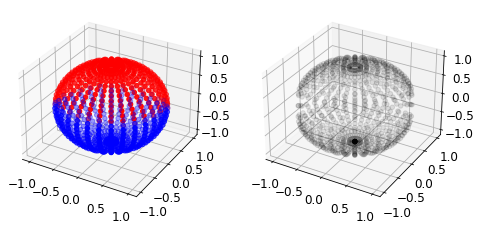

In [163]:
# check the parameterization of each chart separately 
params_x = params_x_i1
#
Xdense_t0 = np.hstack([X_full,np.zeros((len(X_full),1))])
Z_t0 = forward_pass_b(Xdense_t0, params_Z)
Z_t0t0 = np.hstack([Z_t0,np.zeros((len(Z_t0),1))])
x_rt0 = forward_pass_b(Z_t0t0, params_x)
label_full_d = X_full[:,0]+X_full[:,1]+X_full[:,2]
# check the parameterization of each chart separately 
Xdense_t1 = np.hstack([X_full,np.ones((len(X_full),1))])
Z_t1 = forward_pass_b(Xdense_t1, params_Z)
Z_t1t1 = np.hstack([Z_t1,np.ones((len(Z_t1),1))])
x_rt1 = forward_pass_b(Z_t1t1, params_x)
# for last plot get the total parameterization using the classifier
tlabel = jax.nn.sigmoid(100*forward_pass_b(X_full, params_a))
xr = tlabel*x_rt0 + (1-tlabel)*x_rt1
# PLOT
fig,axs = plt.subplots(1,2,figsize=(8,4),subplot_kw={'projection': '3d'})
axs[0].scatter(X_rt1[:,0],X_rt1[:,1],X_rt1[:,2],c=1-tlabel, cmap = cmapblue)
axs[0].scatter(X_rt0[:,0],X_rt0[:,1],X_rt0[:,2],c=tlabel, cmap = cmapred)
axs[1].scatter(xr[:,0],xr[:,1],xr[:,2],color='k',alpha=0.1)

In [164]:
params_x = params_x_i3
eval_dx1rdUVt = grad(lambda z: forward_pass_b(z, params_x)[0])
eval_dx2rdUVt = grad(lambda z: forward_pass_b(z, params_x)[1])
eval_dx3rdUVt = grad(lambda z: forward_pass_b(z, params_x)[2])
eval_dx1rdUVt_vmap = vmap(eval_dx1rdUVt)
eval_dx2rdUVt_vmap = vmap(eval_dx2rdUVt)
eval_dx3rdUVt_vmap = vmap(eval_dx3rdUVt)

In [165]:
# metric for one chart 
dx1rdUVT_t0 = eval_dx1rdUVt_vmap(Z_t0t0)
dx2rdUVT_t0 = eval_dx2rdUVt_vmap(Z_t0t0)
dx3rdUVT_t0 = eval_dx3rdUVt_vmap(Z_t0t0)
# metric for the other chart 
dx1rdUVT_t1 = eval_dx1rdUVt_vmap(Z_t1t1)
dx2rdUVT_t1 = eval_dx2rdUVt_vmap(Z_t1t1)
dx3rdUVT_t1 = eval_dx3rdUVt_vmap(Z_t1t1)

In [166]:
# deformed normals
nx_t0 = dx2rdUVT_t0[:,0]*dx3rdUVT_t0[:,1] - dx3rdUVT_t0[:,0]*dx2rdUVT_t0[:,1]
ny_t0 = dx3rdUVT_t0[:,0]*dx1rdUVT_t0[:,1] - dx1rdUVT_t0[:,0]*dx3rdUVT_t0[:,1]
nz_t0 = dx1rdUVT_t0[:,0]*dx2rdUVT_t0[:,1] - dx2rdUVT_t0[:,0]*dx1rdUVT_t0[:,1]
nx_t0 = nx_t0/np.sqrt(nx_t0**2+ny_t0**2+nz_t0**2)
ny_t0 = ny_t0/np.sqrt(nx_t0**2+ny_t0**2+nz_t0**2)
nz_t0 = nz_t0/np.sqrt(nx_t0**2+ny_t0**2+nz_t0**2)
#
nx_t1 = dx2rdUVT_t1[:,0]*dx3rdUVT_t1[:,1] - dx3rdUVT_t1[:,0]*dx2rdUVT_t1[:,1]
ny_t1 = dx3rdUVT_t1[:,0]*dx1rdUVT_t1[:,1] - dx1rdUVT_t1[:,0]*dx3rdUVT_t1[:,1]
nz_t1 = dx1rdUVT_t1[:,0]*dx2rdUVT_t1[:,1] - dx2rdUVT_t1[:,0]*dx1rdUVT_t1[:,1]
nx_t1 = nx_t1/np.sqrt(nx_t1**2+ny_t1**2+nz_t1**2)
ny_t1 = ny_t1/np.sqrt(nx_t1**2+ny_t1**2+nz_t1**2)
nz_t1 = nz_t1/np.sqrt(nx_t1**2+ny_t1**2+nz_t1**2)
# 
nx = tlabel[:,0]*nx_t0 - (1-tlabel[:,0])*nx_t1
ny = tlabel[:,0]*ny_t0 - (1-tlabel[:,0])*ny_t1
nz = tlabel[:,0]*nz_t0 - (1-tlabel[:,0])*nz_t1
# 
normals = np.vstack([nx,ny,nz]).transpose()

In [167]:
# let's save this 

writeVTK(xr,normals,'sphere_pressurized.vtk')

0